In [1]:
import os
import glob
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torchvision.models as models

In [3]:
def display_images(image_paths, title, max_images=4):
    """지정된 경로의 이미지를 최대 4개까지 출력합니다."""
    plt.figure(figsize=(12, 3))
    for i, image_path in enumerate(image_paths[:max_images]):
        img = plt.imread(image_path)
        plt.subplot(1, max_images, i+1)
        plt.imshow(img)
        plt.title(title)
        plt.axis('off')
    plt.show()

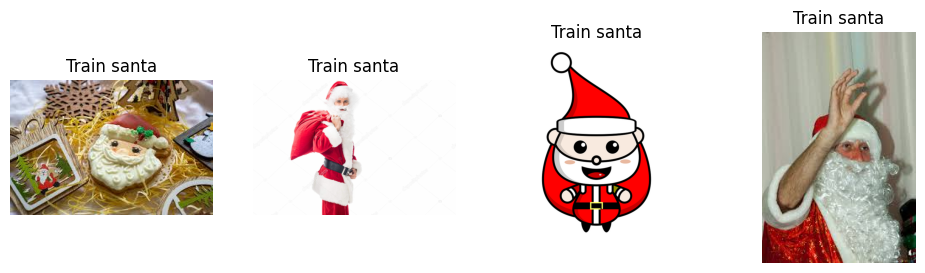

Train santa 총 이미지 수: 446


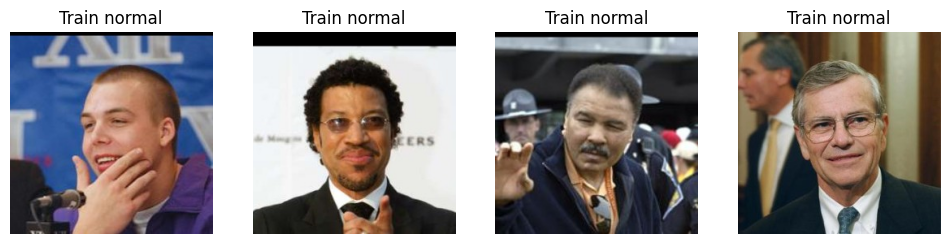

Train normal 총 이미지 수: 449


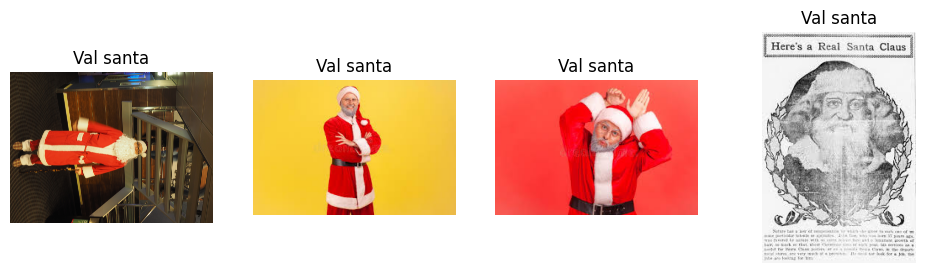

Val santa 총 이미지 수: 133


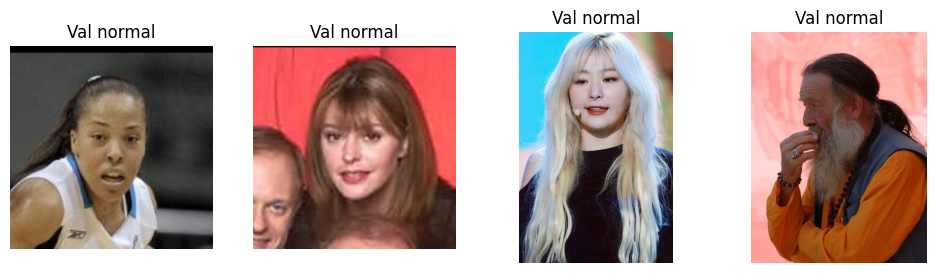

Val normal 총 이미지 수: 134


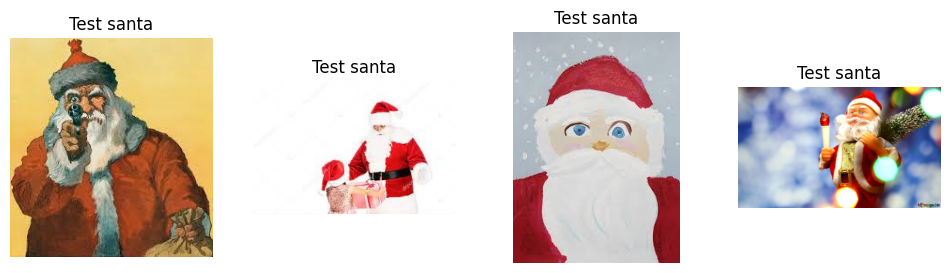

Test santa 총 이미지 수: 36


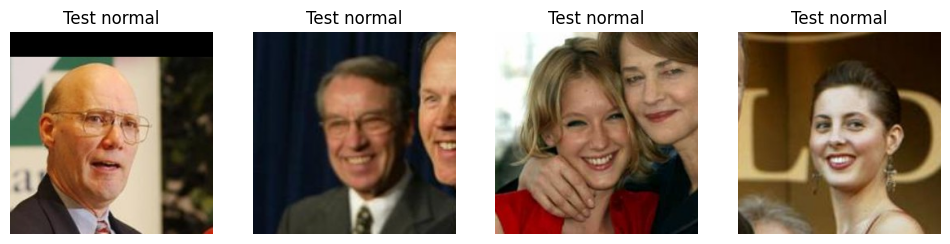

Test normal 총 이미지 수: 32


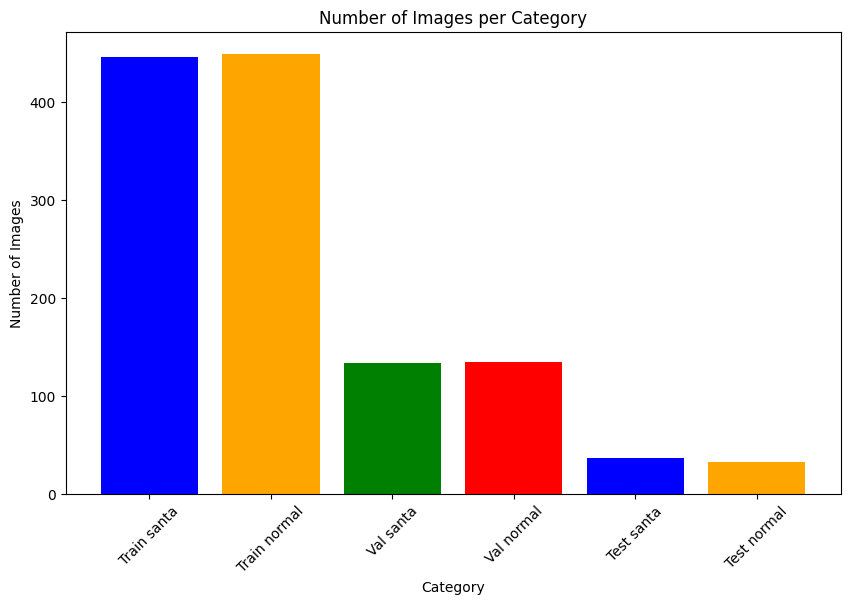

In [6]:
categories = ['Train santa', 'Train normal', 'Val santa', 'Val normal', 'Test santa', 'Test normal']

for category in categories:
    image_paths = glob.glob(f'/Users/taeyoun/Downloads/DeepLearning/project/Image_DL_Fastcampus/Part 1/Chapter 1. Binary Classification _ 두 선택지 중 하나를 선택하여 판별하는 분류 방법/실습 파일/4/{category.lower().replace(" ", "/")}/*')
    display_images(image_paths, category)
    print(f"{category} 총 이미지 수: {len(image_paths)}")

plt.figure(figsize=(10, 6))
plt.bar(categories, [len(glob.glob(f'/Users/taeyoun/Downloads/DeepLearning/project/Image_DL_Fastcampus/Part 1/Chapter 1. Binary Classification _ 두 선택지 중 하나를 선택하여 판별하는 분류 방법/실습 파일/4/{category.lower().replace(" ", "/")}/*')) for category in categories], color=['blue', 'orange', 'green', 'red'])
plt.title('Number of Images per Category')
plt.xlabel('Category')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()

In [8]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 이미지 크기 조정
    transforms.RandomRotation(30),  # 이미지를 최대 30도까지 무작위로 회전
    transforms.ToTensor(),  # 이미지를 텐서로 변환
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 정규화 
])


train_path = '/Users/taeyoun/Downloads/DeepLearning/project/Image_DL_Fastcampus/Part 1/Chapter 1. Binary Classification _ 두 선택지 중 하나를 선택하여 판별하는 분류 방법/실습 파일/4/train'
val_path = '/Users/taeyoun/Downloads/DeepLearning/project/Image_DL_Fastcampus/Part 1/Chapter 1. Binary Classification _ 두 선택지 중 하나를 선택하여 판별하는 분류 방법/실습 파일/4/val'
# 데이터셋 로드 및 데이터 로더 생성
train_dataset = ImageFolder(train_path, transform=transform)
val_dataset = ImageFolder(val_path, transform=transform)

### Train/Val 데이터 로더 생성

In [9]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [10]:
class VGG19(nn.Module):
    def __init__(self, num_classes=1000):
        super(VGG19, self).__init__()
        self.features = nn.Sequential(
            
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes), #기존 논문에서는 1000개의 클래스 분류 문제
            # 시그모이드 활성화 함수는 nn.BCEWithLogitsLoss에 포함
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [11]:
# 사전 학습된 VGG19 모델 불러오기
pretrained_vgg19 = models.vgg19(pretrained=True)
# 새로 정의한 모델 인스턴스 생성
net = VGG19(num_classes=1000) # 이진 분류 문제 with BCEWithLogitsLoss


# 사전 학습된 모델의 features 부분에서 가중치 추출
pretrained_keys = set(pretrained_vgg19.features.state_dict().keys())
# 사전 학습된 모델에서 커스텀 모델로 가중치 복사 시도
result = net.features.load_state_dict(pretrained_vgg19.features.state_dict(), strict=False)
# 복사 후 커스텀 모델의 features 부분에서 가중치 추출
custom_keys = set(net.features.state_dict().keys())


# 성공적으로 복사된 가중치 (커스텀 모델과 사전 학습된 모델 모두에 존재)
successfully_copied_keys = pretrained_keys.intersection(custom_keys)
# 커스텀 모델에 있지만 사전 학습된 모델에 없는 가중치
missing_keys = custom_keys - pretrained_keys
# 사전 학습된 모델에 있지만 커스텀 모델에 없는 가중치
unexpected_keys = pretrained_keys - custom_keys

print("성공적으로 복사된 가중치:", successfully_copied_keys)
print("커스텀 모델에는 있지만 사전 학습된 모델에는 없는 가중치 (누락):", result.missing_keys)
print("사전 학습된 모델에는 있지만 커스텀 모델에는 없는 가중치 (예상치 못한):", result.unexpected_keys) # net 모델에 없는데 pretrained_vgg19 가중치 파일에는 존재하는 항목의 이름이 리스트로 반환

/opt/anaconda3/envs/imagebinary/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/imagebinary/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


성공적으로 복사된 가중치: {'7.bias', '2.bias', '0.weight', '14.weight', '19.bias', '14.bias', '7.weight', '23.weight', '23.bias', '5.bias', '32.weight', '2.weight', '21.bias', '32.bias', '34.bias', '28.weight', '34.weight', '12.bias', '19.weight', '10.bias', '30.bias', '16.bias', '10.weight', '25.bias', '16.weight', '0.bias', '28.bias', '12.weight', '21.weight', '5.weight', '25.weight', '30.weight'}
커스텀 모델에는 있지만 사전 학습된 모델에는 없는 가중치 (누락): []
사전 학습된 모델에는 있지만 커스텀 모델에는 없는 가중치 (예상치 못한): []


In [12]:
# 모델의 모든 파라미터를 고정
for param in net.features.parameters():
    param.requires_grad = False

In [13]:
# classifier 부분의 가중치는 재학습을 위해 새로 정의
net.classifier[6] = nn.Linear(4096, 1)

for param in net.classifier.parameters():
    param.requires_grad = True

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = net.to(device)

In [15]:
print(net)

VGG19(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), pa

In [16]:
# 손실 함수
criterion = nn.BCEWithLogitsLoss()

In [17]:
def validate_model(net, val_loader, criterion):
    net.eval()  # 모델을 평가 모드로 설정
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.float().unsqueeze(1)  # 레이블을 float 타입으로 변환 및 차원 맞춤
            outputs = net(inputs)
            val_loss += criterion(outputs, labels).item()
            predicted = torch.sigmoid(outputs) > 0.5
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = 100 * correct / total
    return val_loss, val_accuracy

In [18]:
import torch.optim as optim

def train_model(optimizer_name, net, train_loader, val_loader, criterion, num_epochs=5):
    # optimizer설정
    if optimizer_name == 'SGD':
        optimizer = optim.SGD(net.parameters(), lr=0.00001, momentum=0.9)
    elif optimizer_name == 'Adam':
        optimizer = optim.Adam(net.parameters(), lr=0.00001, betas=(0.9, 0.999))
    elif optimizer_name == 'RAdam':
        optimizer = optim.RAdam(net.parameters(), lr=0.00001, betas=(0.9, 0.999))
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}")

    # 학습/검증 손실과 검증 정확도를 저장할 리스트
    train_losses = []
    val_losses = []
    val_accuracies = []


    for epoch in range(num_epochs):
        net.train()  # 모델을 학습 모드로 설정
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.float().unsqueeze(1)  # 레이블을 float 타입으로 변환 및 차원 맞춤
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)  # 손실 계산
            loss.backward()
            optimizer.step()
            running_loss += loss.item()


        # 매 에포크마다 평균 학습 손실 계산
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        # 검증 손실 및 정확도 계산
        val_loss, val_accuracy = validate_model(net, val_loader, criterion)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f'[{optimizer_name}] Epoch {epoch + 1}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}, Validation Accuracy: {val_accuracy:.2f}%')


    return train_losses, val_losses, val_accuracies

In [19]:
train_losses_Adam, val_losses_Adam, val_accuracies_Adam = train_model('Adam', net, train_loader, val_loader, criterion)

[Adam] Epoch 1, Train Loss: 0.422481, Val Loss: 0.218885, Validation Accuracy: 92.13%
[Adam] Epoch 2, Train Loss: 0.193100, Val Loss: 0.154517, Validation Accuracy: 93.63%
[Adam] Epoch 3, Train Loss: 0.144637, Val Loss: 0.152600, Validation Accuracy: 92.88%
[Adam] Epoch 4, Train Loss: 0.106995, Val Loss: 0.118314, Validation Accuracy: 96.25%
[Adam] Epoch 5, Train Loss: 0.072556, Val Loss: 0.116557, Validation Accuracy: 95.13%


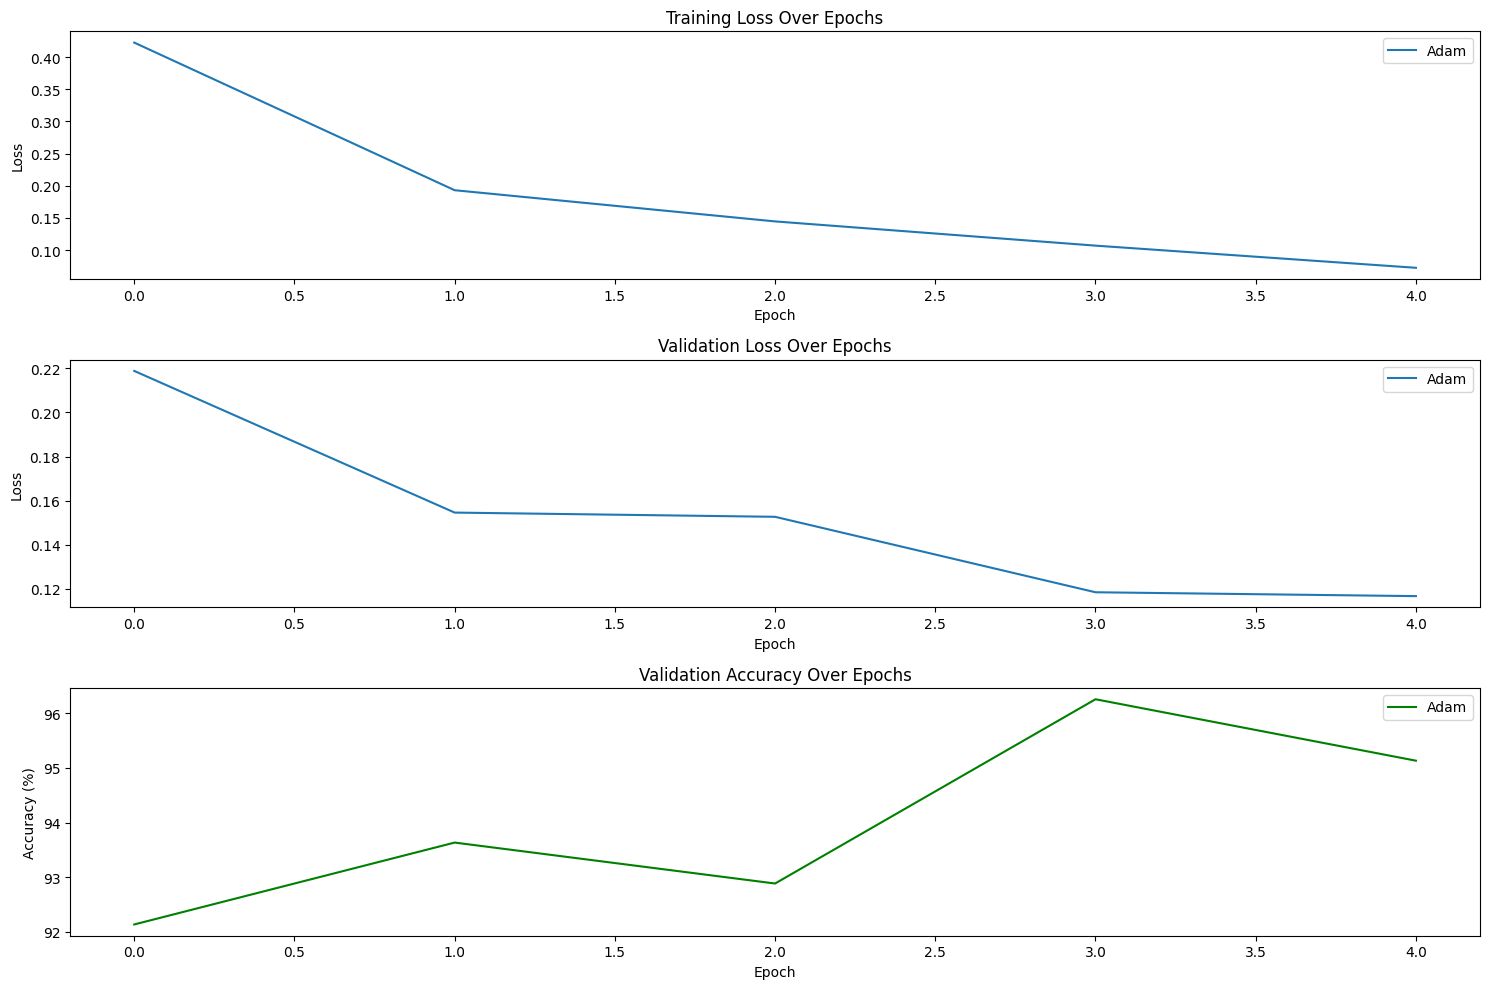

In [20]:
# 학습 손실과 검증 정확도 그래프 그리기
plt.figure(figsize=(15, 10))

# 학습 손실 그래프
plt.subplot(3, 1, 1)  # 3행 1열의 첫 번째 위치
plt.plot(train_losses_Adam, label='Adam')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
# plt.ylim(0, 0.2)

# 검증 손실 그래프
plt.subplot(3, 1, 2)  # 3행 1열의 두 번째 위치
plt.plot(val_losses_Adam, label='Adam')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss Over Epochs')
plt.legend()
# plt.ylim(0, 1.5)

# 검증 정확도 그래프
plt.subplot(3, 1, 3)  # 3행 1열의 세 번째 위치
plt.plot(val_accuracies_Adam, label='Adam', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
# plt.ylim(80, 100)

plt.tight_layout()
plt.show()

In [21]:
# Image load 및 tensor로 변환
def load_and_transform_image(image_path, transform):
    image = Image.open(image_path).convert('RGB')
    return transform(image).unsqueeze(0).to(device)  # 이미지를 모델에 맞게 변환하고 배치 차원 추가

/var/folders/dr/74f443cx0ljg_9kz1_q1ylv80000gn/T/ipykernel_10938/2146829436.py:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(20, 8))


<Figure size 2000x800 with 0 Axes>

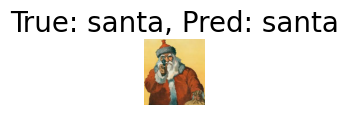

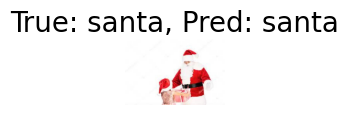

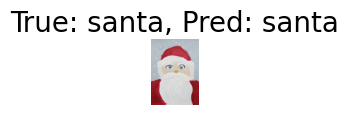

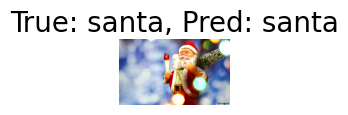

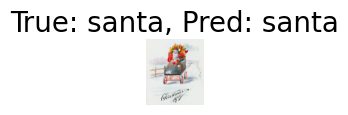

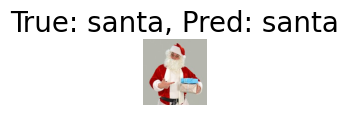

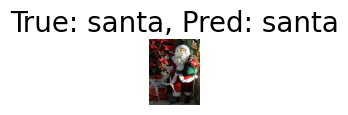

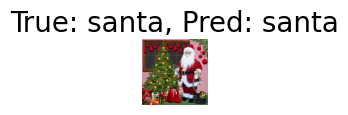

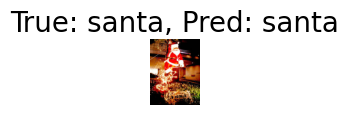

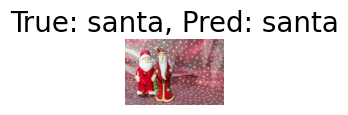

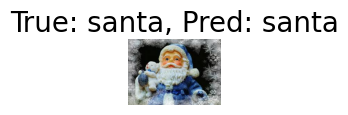

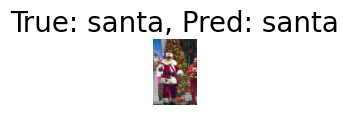

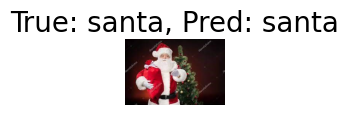

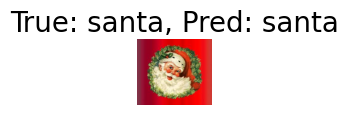

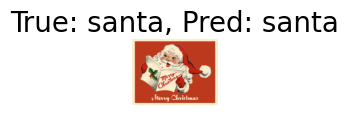

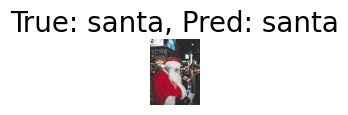

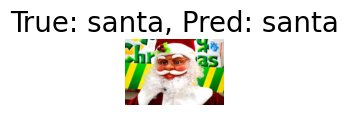

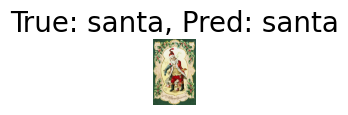

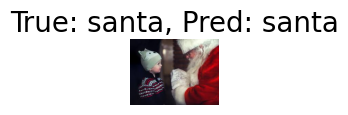

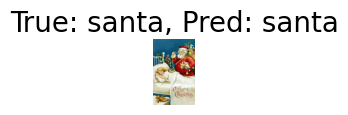

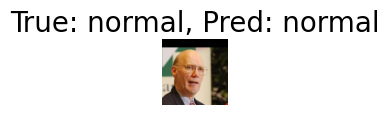

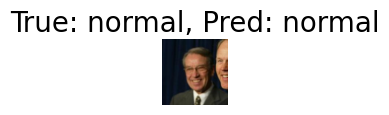

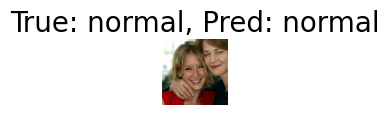

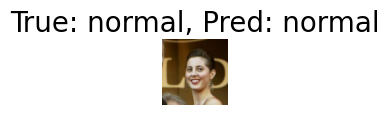

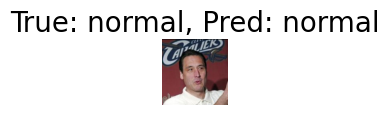

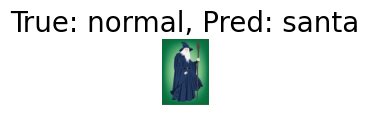

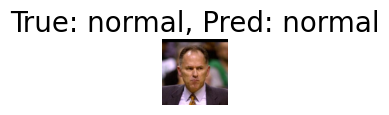

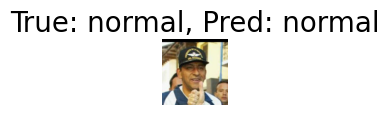

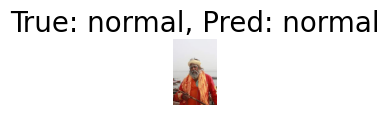

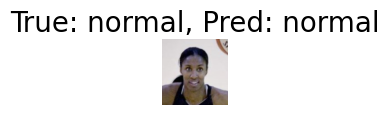

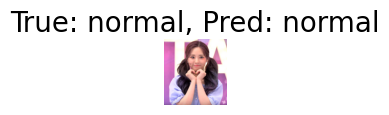

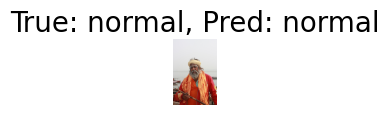

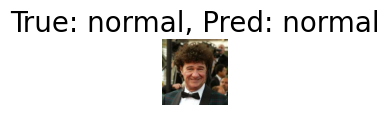

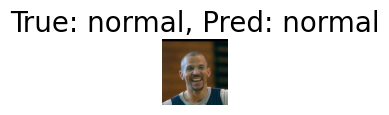

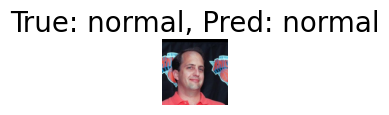

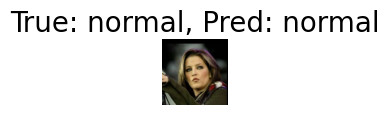

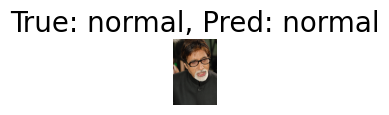

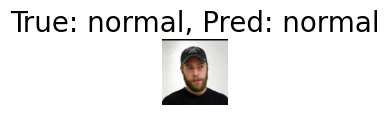

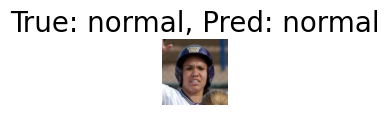

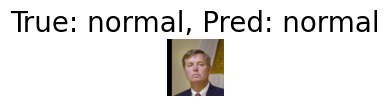

In [27]:
# 클래스별 폴더 경로
class_folders = {
    'santa': '/Users/taeyoun/Downloads/DeepLearning/project/Image_DL_Fastcampus/Part 1/Chapter 1. Binary Classification _ 두 선택지 중 하나를 선택하여 판별하는 분류 방법/실습 파일/4/test/santa',
    'normal': '/Users/taeyoun/Downloads/DeepLearning/project/Image_DL_Fastcampus/Part 1/Chapter 1. Binary Classification _ 두 선택지 중 하나를 선택하여 판별하는 분류 방법/실습 파일/4/test/normal'
}

plt.figure(figsize=(20, 8))
# subplot 인덱스를 위한 카운터
counter = 1

# 각 클래스별로 5장의 이미지 추론 및 시각화
for class_name, folder_path in class_folders.items():
    # 해당 클래스의 이미지 경로 가져오기
    image_paths = glob.glob(os.path.join(folder_path, '*'))
    selected_paths = image_paths[:20]  # 첫 5장 선택

    for image_path in selected_paths:
        image = load_and_transform_image(image_path, transform)

        net.eval()  # 모델을 평가 모드로 설정
        # 모델을 사용한 추론
        with torch.no_grad():
            outputs = net(image)
            # 시그모이드 함수 적용하여 확률 얻기
            probs = torch.sigmoid(outputs).item()
            prediction = 'santa' if probs >= 0.5 else 'normal'

        # 결과 시각화
        plt.figure(figsize=(20, 8))
        plt.subplot(8, 5, counter)
        plt.imshow(Image.open(image_path))
        plt.title(f'True: {class_name}, Pred: {prediction}', fontsize=20)
        plt.axis('off')

        counter += 1  # subplot 인덱스 업데이트

plt.tight_layout()
plt.show()